In [1]:
import pandas as pd # pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
# from sklearn import impute 
from  scipy.stats import skew, kurtosis, shapiro,zscore
import datetime
from sklearn.preprocessing import MinMaxScaler


plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('figure',figsize=(10,8))

def figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16):
    plt.figure(figsize=figsize)
    ax1 = plt.gca()
    plt.rc('legend',fontsize=fontsize_legend)
    plt.title(titel, fontsize=fontsize_titel, fontweight = 'bold')
    plt.grid(True)
    plt.xlabel(xlabel, fontsize=fontsize_axis)
    plt.ylabel(ylabel, fontsize=fontsize_axis)
    for tick in ax1.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_ticks)
    #         tick.label1.set_fontweight('bold')
    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_ticks)
    #     tick.label1.set_fontweight('bold')
    
    return ax1

# fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\FullYeardata.csv",parse_dates=['date'], index_col='date') 
# amount_measurements = fullYeardata.shape[0]
# amount_meters = fullYeardata.shape[1]

# Imputing missing data

In [2]:
# Estimate the missing data based on previous and future observations
def estimated_mean_signal(test):
    # subsitude if necessary the first of january or the last day of december (general) then
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        meanOfSerie = test[col_ID].mean()
        for date in missing_index:
            if date.dayofyear == 1 or date.dayofyear == 365:
            # if date.day == 1 or date.day == 31:
                estimation = meanOfSerie
                test.loc[date,col_ID] = estimation
    
    # subsitude the rest of the days
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        for date in missing_index:
            n = 0
            next_measure_index = date + datetime.timedelta(days= 1)
            next_measure_value = test.loc[next_measure_index,col_ID]
            
            previous_measure_index = date + datetime.timedelta(days= -1)
            previous_measure_value = test.loc[previous_measure_index,col_ID]

            while np.isnan(next_measure_value) or np.isnan(previous_measure_value):
                n += 1
                            
                if np.isnan(next_measure_value) and np.isnan(previous_measure_value):

                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[next_measure_index,col_ID]
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[next_measure_index,col_ID]
                
                elif np.isnan(next_measure_value):
                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[next_measure_index,col_ID]

                elif np.isnan(previous_measure_value):
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[next_measure_index,col_ID]

                else:
                    raise Exception("Should have been excepted by one of the previous cases.")
                

            estimation = (next_measure_value + previous_measure_value)/2
            test.loc[date,col_ID] = estimation

In [3]:
fydc = fullYeardata.copy(deep=True)
fydc.isna().sum()

meter_2979    1344
meter_2980    1584
meter_2981    1344
meter_2982    1392
meter_2983    1392
              ... 
meter_3244    1392
meter_3245    2400
meter_3246    1344
meter_3247    1296
meter_3248    1392
Length: 270, dtype: int64

In [ ]:
# estimation and subsitution of the missing values.
estimated_mean_signal(fydc)
fydc.isna().sum().sum()

In [27]:
fydc.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\no_missing_values.csv")

In [2]:
fydc = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\no_missing_values.csv",parse_dates=['date'], index_col='date') 

# Removing outliers in the yearly consumption.

In [3]:
# fydc_sum = fydc.sum(axis=0)
# print("This is the mean %s and this is the std %s." % (fydc_sum.mean(),fydc_sum.std()))
# fydc_sum

In [4]:
# zscoreArray = zscore(fydc_sum,nan_policy="omit")
# print("The original amount of meters: %s" % len(zscoreArray))
# # remove the meters that have an outlier consumption. (> 3xstd)
# # Assume that the yearly consumption is a normal distributed.
# fydc_new = fydc.loc[:,list(abs(zscoreArray) < 3)]
# print("The new amount of meters after outlier removal: %s" % fydc_new.shape[1])


In [5]:
# axes = figure_layout((10,8),"Zscore","meter ID","",18,16,14,16)
# axes.scatter(np.arange(1,len(zscoreArray)+1), abs(zscoreArray))
# # axes.legend(["Full dataset"])
# plt.show()

# Removing time-series that have days with zero consumption

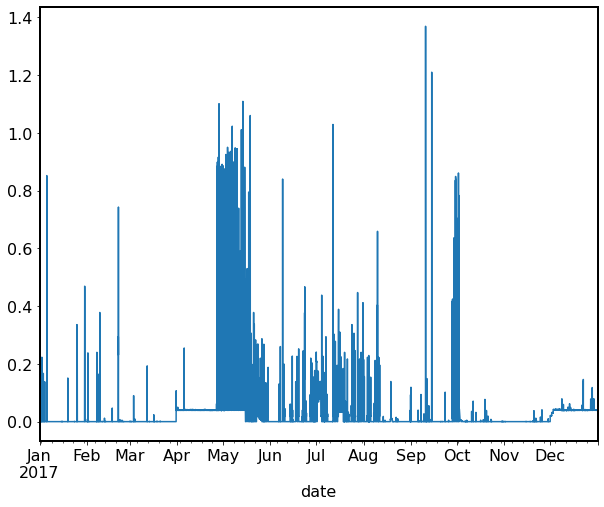

In [6]:
# fyd_no_nan = fydc_new.copy(deep=True)
fyd_no_nan = fydc
fyd_no_nan['meter_2985'].plot()

In [7]:
fydc_new_daily = fyd_no_nan.resample('D',axis=0).sum()
amountZeroDays = dict()

for col in fydc_new_daily.columns:
    count = 0
    for row in fydc_new_daily.index:
        value = fydc_new_daily.loc[row,col]
        if value == 0:
            count = count + 1
    amountZeroDays[col] = count

In [8]:
originalLength = fyd_no_nan.shape[1]
for key in amountZeroDays:
    if amountZeroDays[key] > 0:
        fyd_no_nan.drop(key,axis=1,inplace=True)
        print("Meter that is dropped: %s."%(key))
newLength = fyd_no_nan.shape[1]
print("Amount of meters original: %s.\nAfter removal: %s."%(originalLength,newLength))


Meter that is dropped: meter_2985.
Meter that is dropped: meter_3049.
Meter that is dropped: meter_3064.
Meter that is dropped: meter_3140.
Meter that is dropped: meter_3175.
Meter that is dropped: meter_3186.
Meter that is dropped: meter_3194.
Meter that is dropped: meter_3225.
Meter that is dropped: meter_3231.
Amount of meters original: 270.
After removal: 261.


In [9]:
fyd_no_nan.shape

(17520, 261)

# Normalizing time-series
Normalizing is done by looking at the minimum and maximum in the time-serie.

In [10]:
# fyd_no_nan.head()

In [11]:
fyc_update = fyd_no_nan.copy(deep=True)


In [12]:
# Every time serie is individually normalized.

In [13]:
# fydc_sum = fydc_non_nan.sum(axis=0)
for col in fyc_update.columns:
    meter = fyc_update[col]
    meter_sum = meter.sum()
    fyc_update[col] = meter/meter_sum
fyc_update.head()

,meter_2979,meter_2980,meter_2981,meter_2982,meter_2983,meter_2984,meter_2986,meter_2987,meter_2988,meter_2989,...,meter_3239,meter_3240,meter_3241,meter_3242,meter_3243,meter_3244,meter_3245,meter_3246,meter_3247,meter_3248
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.000036,0.000064,0.000112,0.000009,0.000060,0.000004,0.000083,0.000102,0.000069,0.000049,...,0.000031,0.000004,0.000041,0.000002,0.000036,0.000006,0.000007,0.000105,0.000035,0.000005
2017-01-01 00:30:00,0.000044,0.000420,0.000491,0.000008,0.000067,0.000106,0.000103,0.000052,0.000076,0.000040,...,0.000389,0.000739,0.000042,0.000222,0.000035,0.000558,0.000726,0.000131,0.000519,0.000490
2017-01-01 01:00:00,0.000036,0.000421,0.000404,0.000012,0.000057,0.000029,0.000097,0.000020,0.000071,0.000044,...,0.000396,0.000743,0.000025,0.000036,0.000037,0.000007,0.000050,0.000046,0.000318,0.000298
2017-01-01 01:30:00,0.000042,0.000131,0.000477,0.000085,0.000052,0.000037,0.000063,0.000019,0.000072,0.000045,...,0.000341,0.000523,0.000037,0.000041,0.000047,0.000104,0.000141,0.000027,0.000251,0.000313
2017-01-01 02:00:00,0.000038,0.000085,0.000219,0.000419,0.000190,0.000034,0.000025,0.000008,0.000077,0.000042,...,0.000228,0.000420,0.000036,0.000002,0.000039,0.000008,0.000032,0.000021,0.000290,0.000302


In [14]:
# meter_min_max = dict()
# for col in fyc_update.columns:
#     ser = fyc_update[col]
#     values = ser.values
#     values = values.reshape((len(values), 1))
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaler = scaler.fit(values)
#     print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
#     addList = [scaler.data_min_,scaler.data_max_]
#     meter_min_max[col] = addList
#     normalized = scaler.transform(values)
#     fyc_update[col] = normalized
# fyc_update.head()

# Removing time-series with a fundamental change in the data.

In [15]:
fyc_norm = fyc_update.copy(deep=True)

In [16]:
rolling_df = pd.DataFrame(index=fyc_norm.index)

In [17]:
# By default the result of the window is set to the right edge of the window. Therefore, the first week is calculated by a variable size and should be removed.
# By default a window is used that are all evenly weighted.
for col in fyc_norm.columns:
    rolling_mean = fyc_norm[col].rolling(window='7D').mean()
    rolling_df[col] = rolling_mean
for rowName in rolling_df.index[0:336]:
    rolling_df.drop(rowName,inplace=True)

In [18]:
difference_min_max = rolling_df.max(axis=0) - rolling_df.min(axis=0)

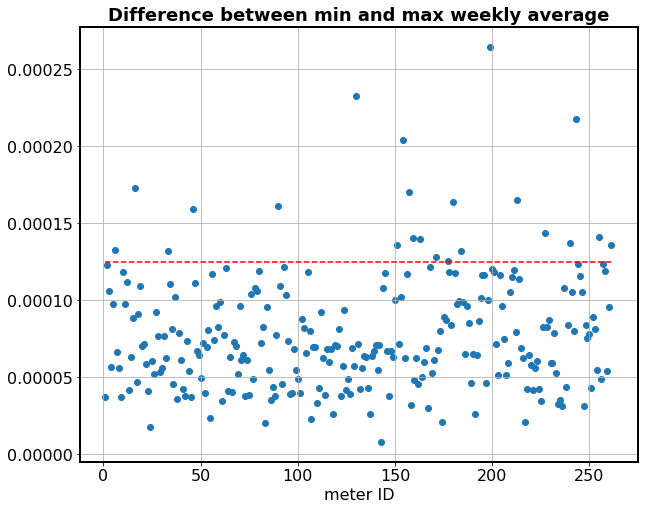

In [19]:
axes = figure_layout((10,8),"Difference between min and max weekly average","meter ID","",18,16,14,16)
plt.hlines(y=0.000125,xmin=1,xmax=len(difference_min_max)+1,colors='r',linestyles='dashed')
axes.scatter(np.arange(1,len(difference_min_max)+1), difference_min_max)
# axes.legend(["Full dataset"])

plt.show()

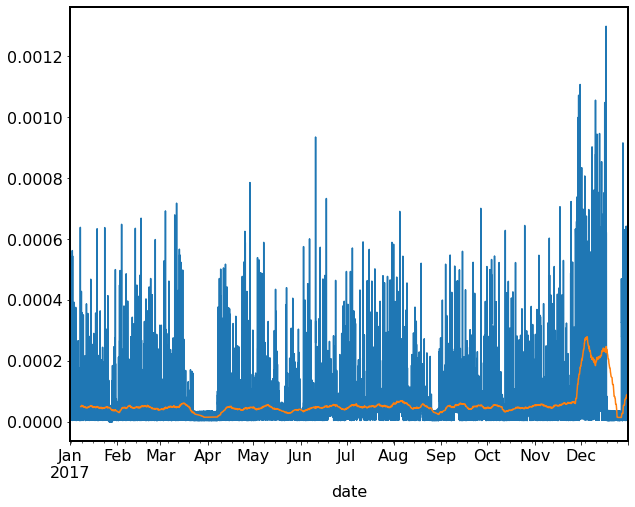

In [20]:
# serie with originally the biggest difference
max_diff = difference_min_max.idxmax()
fyc_norm[max_diff].plot()
rolling_df[max_diff].plot()

In [21]:
fyc_norm.loc[:,list(np.array(difference_min_max) > 0.000125)].columns

Index(['meter_2984', 'meter_2995', 'meter_3012', 'meter_3025', 'meter_3071',
       'meter_3111', 'meter_3132', 'meter_3135', 'meter_3138', 'meter_3141',
       'meter_3145', 'meter_3153', 'meter_3159', 'meter_3162', 'meter_3166',
       'meter_3182', 'meter_3198', 'meter_3212', 'meter_3226', 'meter_3229',
       'meter_3242', 'meter_3248'],
      dtype='object')

In [22]:
print("original amount of meters: %s."%fyc_norm.shape[1])
fyc_norm_new = fyc_norm.loc[:,list(np.array(difference_min_max) <= 0.000125)]
print("New amount of meters: %s."%fyc_norm_new.shape[1])

original amount of meters: 261.
New amount of meters: 239.


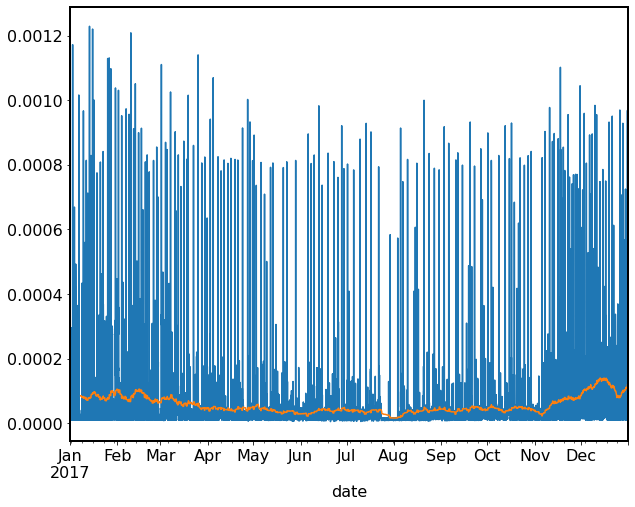

In [23]:
# serie with the biggest difference
new_difference_min_max = difference_min_max[difference_min_max <=0.000125]
max_diff = new_difference_min_max.idxmax()
fyc_norm[max_diff].plot()
rolling_df[max_diff].plot()

Now do the same for a month

In [24]:
# fyc_norm = fyc_update.copy(deep=True)
# rolling_df = pd.DataFrame(index=fyc_norm.index)
# # By default the result of the window is set to the right edge of the window. Therefore, the first week is calculated by a variable size and should be removed.
# # By default a window is used that are all evenly weighted.
# for col in fyc_norm.columns:
#     rolling_mean = fyc_norm[col].rolling(window='30D').mean()
#     rolling_df[col] = rolling_mean
# for rowName in rolling_df.index[0:336]:
#     rolling_df.drop(rowName,inplace=True)
# difference_min_max = rolling_df.max(axis=0) - rolling_df.min(axis=0)
# axes = figure_layout((10,8),"Difference between min and max monthly average","meter ID","",18,16,14,16)
# plt.hlines(y=0.00015,xmin=1,xmax=len(difference_min_max)+1,colors='r',linestyles='dashed')
# axes.scatter(np.arange(1,len(difference_min_max)+1), difference_min_max)
# # axes.legend(["Full dataset"])

# plt.show()

In [25]:
# # serie with originally the biggest difference
# max_diff = difference_min_max.idxmax()
# fyc_norm[max_diff].plot()
# rolling_df[max_diff].plot()

In [26]:
# fyc_norm.loc[:,list(np.array(difference_min_max) > 0.0001125)].columns

In [27]:
# print("original amount of meters: %s."%fyc_norm.shape[1])
# fyc_norm_new2 = fyc_norm.loc[:,list(np.array(difference_min_max) <= 0.00015)]
# print("New amount of meters: %s."%fyc_norm_new.shape[1])

In [28]:
# # serie with the biggest difference
# new_difference_min_max = difference_min_max[difference_min_max <=0.00015]
# max_diff = new_difference_min_max.idxmax()
# fyc_norm[max_diff].plot()
# rolling_df[max_diff].plot()

# The average time-serie of the remaining houses.

In [29]:
fyc_final = fyc_norm_new.copy(deep=True)

In [30]:
av_fyc_final_a = fyc_final.mean(axis=1)
# # again normalize after averaging
# values = av_fyc_final_a.values
# values = values.reshape((len(values), 1))
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(values)
# print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# av_fyc_final = scaler.transform(values)
# av_fyc_final = np.array(av_fyc_final).squeeze()
# av_fyc_final = pd.Series(data=av_fyc_final,index=av_fyc_final_a.index)
# print(av_fyc_final)

av_fyc_final = pd.Series(data=av_fyc_final_a,index=av_fyc_final_a.index)
print(av_fyc_final)

date
2017-01-01 00:00:00    0.000048
2017-01-01 00:30:00    0.000072
2017-01-01 01:00:00    0.000055
2017-01-01 01:30:00    0.000051
2017-01-01 02:00:00    0.000050
                         ...   
2017-12-31 21:30:00    0.000069
2017-12-31 22:00:00    0.000069
2017-12-31 22:30:00    0.000063
2017-12-31 23:00:00    0.000056
2017-12-31 23:30:00    0.000055
Length: 17520, dtype: float64


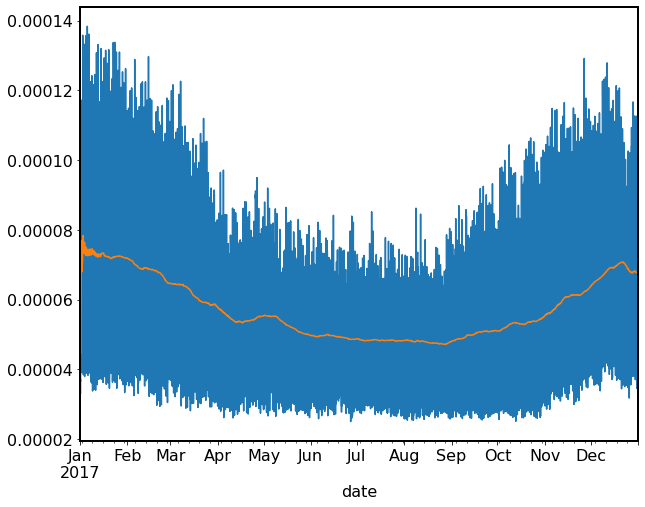

In [31]:
fyc_final["av_final"] = av_fyc_final
rolling_mean = av_fyc_final.rolling(window='14D').mean()
av_fyc_final.plot()
rolling_mean.plot()
plt.show()

In [32]:
fyc_final.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\fyc_final.csv")

In [33]:
# fyc_final = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\fyc_final.csv",parse_dates=['date'], index_col='date') 

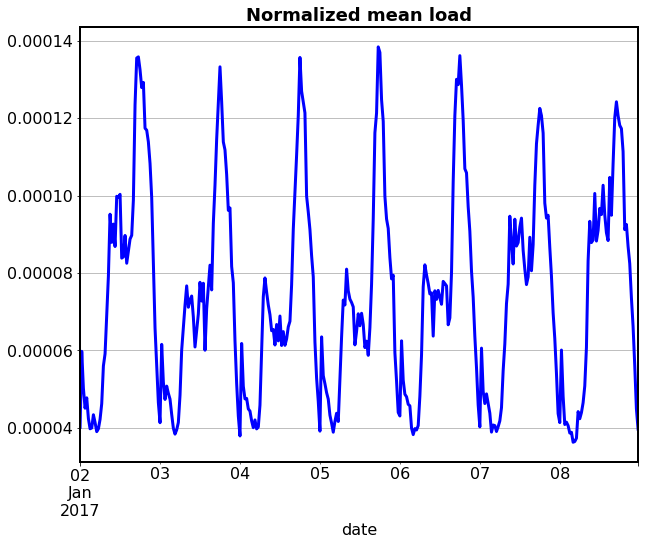

In [34]:
axes1 = figure_layout(titel="Normalized mean load",xlabel="date")
fyc_final.loc[list(fyc_final.index.weekofyear == 1),"av_final"].plot(grid=True, ax = axes1,lw=3.0,style='b')

# Daily and weekly filters
The daily and weekly filter as described in 'Short term load forecasting with seasonal
decomposition using evolution for parameter tuning'. 


In [35]:
obs = np.zeros(48)
obs_index = fyc_final.index[fyc_final.index.dayofyear == 1]
for day in range(1,365+1,1):
    temp = fyc_final.loc[list(fyc_final.index.dayofyear == day),"av_final"]
    data = temp.values
    obs = obs + data
obs = obs/365
day_filter = pd.Series(data=obs,index=obs_index)

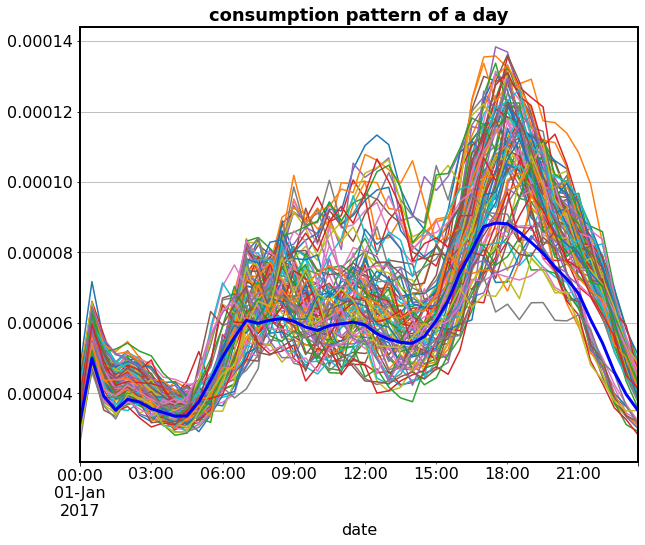

In [36]:
# The typical consumption of one day
axes1 = figure_layout(titel="consumption pattern of a day",xlabel="date")
for i in range(1,100):
    temp = fyc_final.loc[list(fyc_final.index.dayofyear == i),"av_final"]
    values = temp.values
    temp = pd.Series(data=values,index=obs_index)
    temp.plot(ax=axes1,grid=True)
day_filter.plot(ax=axes1,grid=True,lw=3.0,style='b')
plt.show()

In [37]:
# The typical consumption of one week
obs = np.zeros(336)
obs_index = fyc_final.index[fyc_final.index.weekofyear == 1]
for week in range(1,52,1):
    temp = fyc_final.loc[list(fyc_final.index.weekofyear == week),"av_final"]
    data = temp.values
    obs = obs + data
obs = obs/51
week_filter = pd.Series(data=obs,index=obs_index)

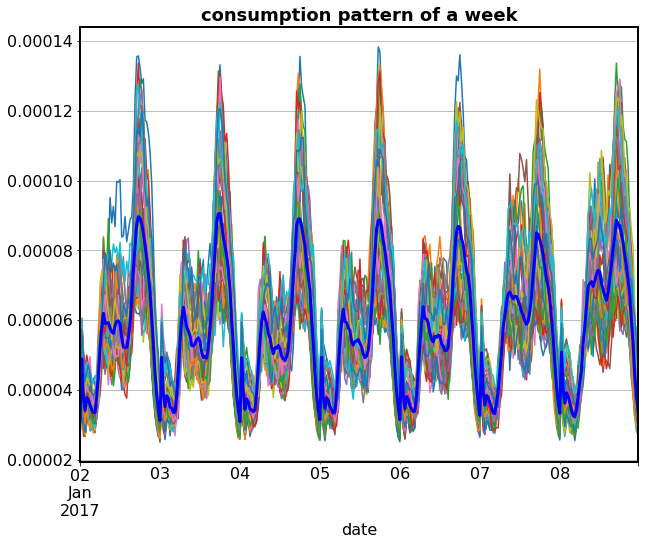

In [38]:
# The typical consumption of one day
axes2 = figure_layout(titel="consumption pattern of a week",xlabel="date")
for i in range(1,52):
    temp = fyc_final.loc[list(fyc_final.index.weekofyear == i),"av_final"]
    values = temp.values
    temp = pd.Series(data=values,index=obs_index)
    temp.plot(ax=axes2,grid=True)
week_filter.plot(ax=axes2,grid=True,lw=3.0,style='b')

plt.show()

# Influence of temperature

In [39]:
fyc_final = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\fyc_final.csv",parse_dates=['date'], index_col='date') 

In [40]:
fyc_final_new = fyc_final.copy(deep=True)

In [41]:
originalData = pd.read_csv("D:\Onedrive\Leuven\Final project\data\consumption.csv") 

In [42]:
av_temperature = pd.read_csv("D:\Onedrive\Leuven\Final project\data\weather-avg.csv") 

In [43]:
av_temperature.set_index(av_temperature["meter_id"],inplace=True)
col = av_temperature.columns[0]
av_temperature.drop(labels= col,axis=1,inplace=True)
av_temperature.head()

,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,...,2017-12-22 00:00:00,2017-12-23 00:00:00,2017-12-24 00:00:00,2017-12-25 00:00:00,2017-12-26 00:00:00,2017-12-27 00:00:00,2017-12-28 00:00:00,2017-12-29 00:00:00,2017-12-30 00:00:00,2017-12-31 00:00:00
meter_id,,,,,,,,,,,,,,,,,,,,,
0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,4.904167,1.275000,2.225000,4.266667,0.262500,1.570833,7.833333,8.391667,6.904167,6.079167,...,8.666667,8.370833,8.662500,9.645833,4.008333,1.491667,0.5625,2.925000,9.383333,9.462500
0xc53b26e7f9cc49e8131409db6e3bc47a2b7cee20,4.904167,1.275000,2.225000,4.266667,0.262500,1.570833,7.833333,8.391667,6.904167,6.079167,...,8.666667,8.370833,8.662500,9.645833,4.008333,1.491667,0.5625,2.925000,9.383333,9.462500
0x99c6ba65bec5c1e83f8c19f6518178c87732c406,5.391667,1.550000,2.883333,4.691667,0.729167,1.566667,7.650000,8.295833,7.345833,6.320833,...,8.695833,8.595833,8.845833,9.591667,4.545833,2.225000,1.2625,3.308333,9.304167,9.708333
0x8f04b8efaa48f13810f51e4b361961226d718ef1,5.250000,1.237500,2.287500,4.612500,0.954167,1.791667,6.745833,7.358333,6.908333,5.645833,...,8.195833,8.429167,8.712500,9.987500,4.270833,2.529167,0.3375,2.225000,8.462500,9.404167
0x1a586297008785374c9de5073e7781d14d105bc8,5.370833,1.529167,3.045833,4.341667,0.670833,1.812500,6.745833,7.691667,6.841667,6.195833,...,8.612500,7.983333,8.650000,9.841667,4.187500,2.370833,1.1875,1.908333,7.775000,9.270833


In [44]:
daysin2017 = pd.date_range(start='2017-1-1 00:00:00',end='2017-12-31 00:00:00',freq='D',name="date")

In [45]:
originalID = dict()
for name in fyc_final_new.columns[0:-1]:
    number = name.split("_")
    number = number[1]
    number = int(number) 
    number_row = number - 1 # started with meter 1
    originalID[name] = originalData["meter_id"].iloc[number_row]

In [46]:
av_temperature_update = pd.DataFrame(index=daysin2017)
for name in originalID:
    originalName = originalID[name]
    data = av_temperature.loc[originalName,:].values
    av_temperature_update[name] = data

In [47]:
amount_of_missing_values = av_temperature_update.isnull().sum().sum()
print("The amount of missing values: %s"%(amount_of_missing_values))

The amount of missing values: 89


In [48]:
# imputing missing values in the dataframe by the average of each corresponding column.
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(av_temperature_update) # calculating the mean of each column and switch it with the missing values of the column
av_temperature_update_no_missing = pd.DataFrame(data = data_with_imputed_values,index=av_temperature_update.index,columns=av_temperature_update.keys())
amount_of_missing_values = av_temperature_update_no_missing.isnull().sum().sum()
print("The amount of missing values: %s"%(amount_of_missing_values))

The amount of missing values: 0


In [49]:
av_temperature_update_no_missing.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\av_temperature_update.csv")

Min: -0.848272, Max: 23.696859


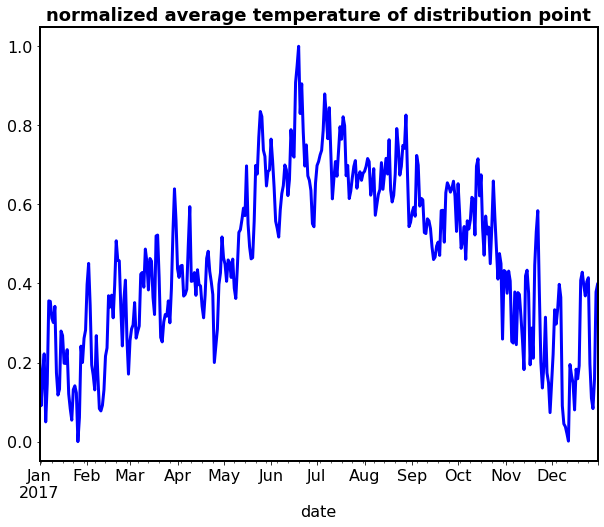

In [50]:
consumption = fyc_final_new.av_final.resample(axis='index',rule='D').sum()
temperature = av_temperature_update_no_missing.mean(axis=1)
values = temperature.values
values = values.reshape((len(values), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
norm_temp_data = scaler.transform(values)
norm_temp_data = np.array(norm_temp_data).squeeze()
norm_temp = pd.Series(data=norm_temp_data,index=temperature.index)
axes3 = figure_layout(titel="normalized average temperature of distribution point",xlabel="date")
norm_temp.plot(lw=3.0,style='b')

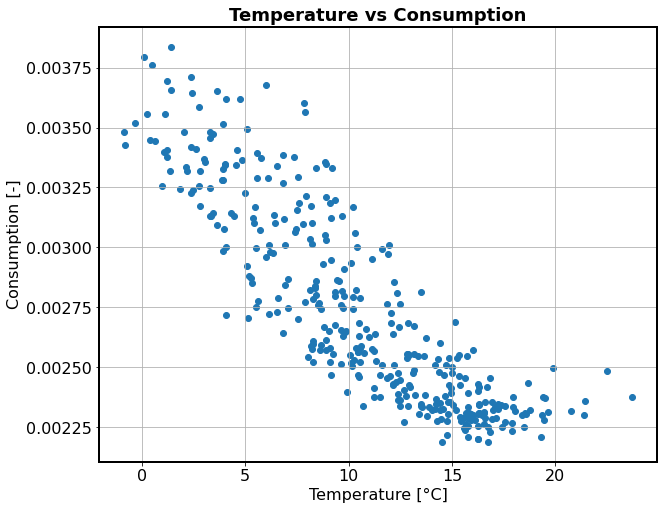

In [51]:
axes4 = figure_layout((10,8),titel="Temperature vs Consumption",ylabel="Consumption [-]",xlabel="Temperature [°C]")
axes4.scatter(temperature.values,consumption.values)
plt.show()

In [52]:
# pearson correlation
outp = temperature.corr(consumption,method='pearson')
print(np.around(outp,2))
# Spearman correlation
outp = temperature.corr(consumption,method='spearman')
print(np.around(outp,2))
# Kendall correlation
outp = temperature.corr(consumption,method='kendall')
print(np.around(outp,2))

-0.87
-0.89
-0.7


# Influence of holidays

In [56]:
av_temperature_update_no_missing = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\av_temperature_update.csv",parse_dates=['date'], index_col='date') 
temperature = av_temperature_update_no_missing.mean(axis=1)

In [57]:
fyc_final = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\fyc_final.csv",parse_dates=['date'], index_col='date') 
consumption =fyc_final.av_final

In [58]:
daily_consumption = consumption.resample('D',axis=0).sum()
daily_consumption

date
2017-01-01    0.003619
2017-01-02    0.003837
2017-01-03    0.003481
2017-01-04    0.003408
2017-01-05    0.003446
                ...   
2017-12-27    0.003242
2017-12-28    0.003406
2017-12-29    0.003368
2017-12-30    0.003331
2017-12-31    0.003347
Freq: D, Name: av_final, Length: 365, dtype: float64

In [59]:
import pandas as pd
from pandas.tseries.holiday import (
    AbstractHolidayCalendar, DateOffset, EasterMonday,
    GoodFriday, Holiday, MO,
    next_monday, next_monday_or_tuesday)
class EnglandAndWalesHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=next_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May bank holiday',
                month=5, day=1, offset=DateOffset(weekday=MO(1))),
        Holiday('Spring bank holiday',
                month=5, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Summer bank holiday',
                month=8, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Christmas Day', month=12, day=25, observance=next_monday),
        Holiday('Boxing Day',
                month=12, day=26, observance=next_monday_or_tuesday)
    ]

In [60]:
from datetime import date
holidays = EnglandAndWalesHolidayCalendar().holidays(start=date(2017, 1, 1),end=date(2017, 12, 31))
holidays

DatetimeIndex(['2017-01-02', '2017-04-14', '2017-04-17', '2017-05-01',
               '2017-05-29', '2017-08-28', '2017-12-25', '2017-12-26'],
              dtype='datetime64[ns]', freq=None)

In [61]:
from pandas.tseries.offsets import CustomBusinessDay
Bcalendar = CustomBusinessDay(calendar=EnglandAndWalesHolidayCalendar())
businessDays = pd.date_range('2017-01-01', end='2017-12-31', freq=Bcalendar)
businessDays

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-16',
               ...
               '2017-12-14', '2017-12-15', '2017-12-18', '2017-12-19',
               '2017-12-20', '2017-12-21', '2017-12-22', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', length=252, freq='C')

In [62]:
consumptionHolidays = daily_consumption[holidays]
temperatureHolidays = temperature[holidays]

In [66]:
temperatureBusinessDays = temperature[businessDays]

2017-01-03    3.296005
2017-01-04    4.602127
2017-01-05    0.378495
2017-01-06    2.737826
2017-01-09    6.818288
                ...   
2017-12-21    9.670447
2017-12-22    8.874146
2017-12-27    1.845484
2017-12-28    1.201411
2017-12-29    3.021741
Freq: C, Length: 252, dtype: float64

In [68]:
# A business day also doesn't take weekends into account.
con = []
for temp in temperatureHolidays.values:
    date = abs(temperatureBusinessDays - temp).idxmin()
    print(date)
    con.append(daily_consumption.loc[date])
print(con)

2017-12-08 00:00:00
2017-11-15 00:00:00
2017-01-11 00:00:00
2017-04-20 00:00:00
2017-06-09 00:00:00
2017-07-07 00:00:00
2017-03-20 00:00:00
2017-01-18 00:00:00
[0.0033182164487816834, 0.002909272111908102, 0.0032924268065255345, 0.0025811125026257847, 0.0023422976615245163, 0.002281282368281837, 0.002796731188908546, 0.0033429759563967086]


In [ ]:
# find business 

# Influence of holidays

# Influence of household data
maybe not so important